# CGAN-DenseNet

**Notes about this specific notebook**

Uses rgb, 64x64 images with ReLU activation and Adam optimizer. No class or sample specific weights are used. Same as cnn-kaggle-v021

This notebook is set up for cross-validation, which is freq. used in research

# Changeable Parameters

_____________________________________________________________________

In [1]:
# Image size (height x width)
ih = 64
iw = 64

# Grayscale or RGB
ch = 'rgb'

# Batch size
batch_size = 150000

# Number of epochs
epoch_t = 35

# Where computation is performed: Kaggle (0) or Local (1)
cenv = 1

# Division of the training vs. test set 
test_size = 0.3

# number of folds
n_folds = 10

_____________________________________________________________________

In [2]:
# To check whether the right environment has been selected
if cenv == 0:
    print("Computation environment: Kaggle")
if cenv == 1:
    print("Computation environment: Local")

Computation environment: Local


Import the necessary libraries

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras import datasets, layers, models, losses, Model
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
from sklearn import metrics
import sys
import os
from math import log
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Check whether a, and which GPU is available for the computation

In [4]:
is_cuda_gpu_available = tf.config.list_physical_devices('GPU')
print(is_cuda_gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Image size
im_si = (ih, iw)

# Convert the color channel to the corresponding number of layers
if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

Create new directory for saving output files if computation is done locally

In [6]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/Documents/GitHub/cross_validation"
    for files in os.listdir(dir):
        if "cgan-densenet" in files:
            try:
                vnum = max(vnum, int(files[-3:]))
            except: 
                continue
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: crossv-cgan-densenet-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"/Users/Max/Documents/GitHub/cross_validation/crossv-cgan-densenet-local-v{new_vnum:03}"
    os.makedirs(new_dir)

No matches found
New folder name: crossv-cgan-densenet-local-v001
--------------


**Data**


In [7]:
if cenv == 0:
    path_root = "/kaggle/input/thesis-data"
    path_root_gen = '/kaggle/input/cganlocalv007/cgan-local-v007'

if cenv == 1:
    path_root = "C:/Users/Max/Documents/thesis_data"
    path_root_gen = "C:/Users/Max/Documents/image_data/cgan-ckpt-v009-thirdsize"

Load the data. No data augmentation takes place

In [8]:
batches = ImageDataGenerator().flow_from_directory(
    directory     = path_root, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic'
)
imgs, labels = next(batches)

Found 26548 images belonging to 11 classes.


Load CGAN generated images

In [9]:
batches_gen = ImageDataGenerator().flow_from_directory(
    directory     = path_root_gen, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic'
)
imgs_gen, labels_gen = next(batches_gen)

Found 42528 images belonging to 10 classes.


Original images

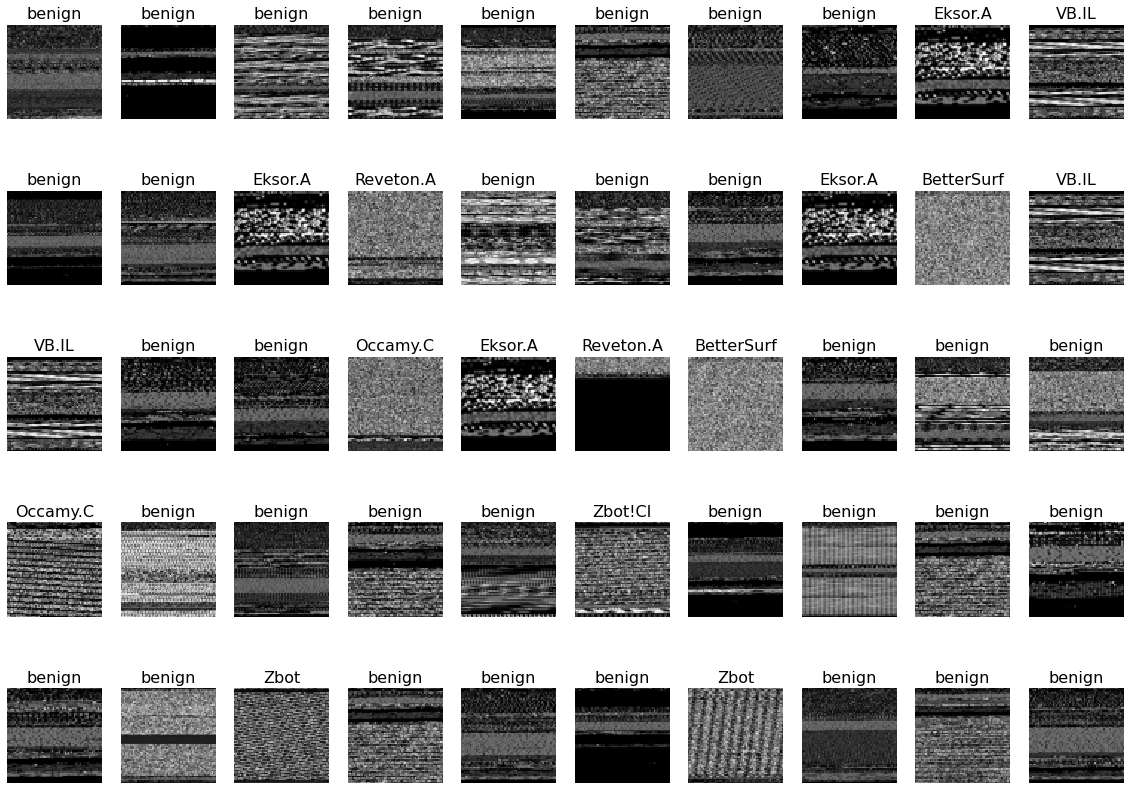

In [10]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != chnum):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], cmap = 'gray',interpolation=None if interp else 'none')
        
plots(imgs, titles = labels)

Generated images

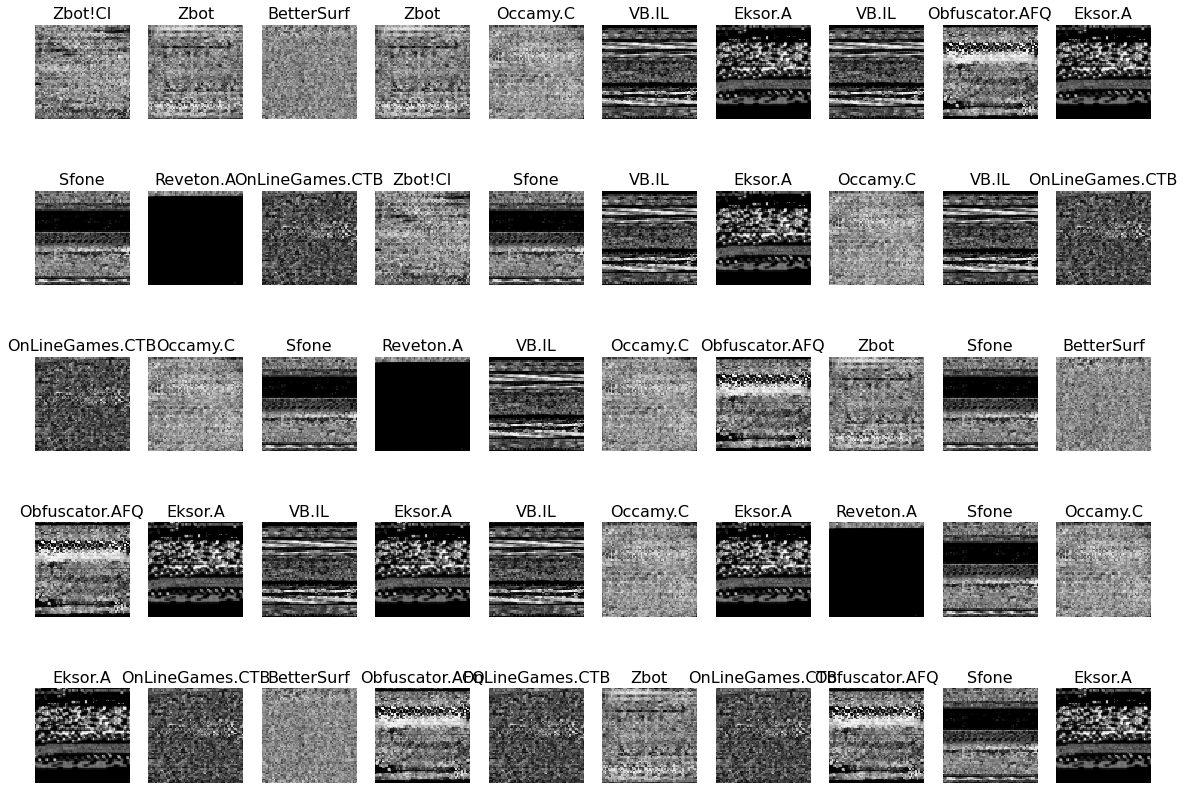

In [11]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != chnum):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], cmap = 'gray',interpolation=None if interp else 'none')
        
plots(imgs_gen, titles = labels_gen)

In [12]:
# A dictionary of all the different classes
classes = batches.class_indices.keys()
x_axis = np.arange(len(list(classes)))

Plot data distribution among all classes

Standardize images

In [13]:
imgs = imgs / 255.0
imgs_gen = imgs_gen / 255.0

Plot data distribution among train, val. and test set

# CGAN - DenseNet169
We will now build our **DenseNet169** model using Keras. This model will have the following layers :

**Input shape** : 64 * 64 * 3

Nota bene that the DenseNet only takes RGB images (with 3 channels)

In [14]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical

In [15]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

We want **11** classes

In [16]:
num_classes = len(list(batches.class_indices))
print("The number of classes in our dataset: ", num_classes)

The number of classes in our dataset:  11


In [17]:
def confusion_matrix(confusion_matrix, class_names_bin, figsize = (5,2), fontsize=7):

        df_cm = pd.DataFrame(
            confusion_matrix, index=class_names_bin, columns=class_names_bin, 
        )
        fig = plt.figure(figsize=figsize)
        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

class_names_bin= ("ransomware", "benign")

Reduce learning rate after 5 epochs of no improvement on the validition accuracy. Also save save checkpoints for the best performing model based on validation loss

In [18]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
if cenv == 0:
    checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
if cenv == 1:
    checkpoint = ModelCheckpoint(f'{new_dir}/model.h5', verbose=1, save_best_only=True)


In [19]:
# Performance metrics
multi_acc_per_fold = []
loss_per_fold = []
multi_f1_per_fold = []
bin_acc_per_fold = []
bin_tpr_per_fold = []
bin_f1_per_fold = []
bin_mcc_per_fold = []

tp = []
fp = []
fn = []
tn = []

# Predictions
y_pred = []
y_true = []

# History
history = []

# Data distribution
train_distr = []
test_distr= []

rw_count = []
bn_count = []

In [20]:
kfold = KFold(n_splits=n_folds, shuffle=True)

Epoch 1/35
2076/2076 [==============================] - 258s 118ms/step - loss: 0.2643 - accuracy: 0.9497 - val_loss: 0.2520 - val_accuracy: 0.9250

Epoch 00001: val_loss improved from inf to 0.25199, saving model to /Users/Max/Documents/GitHub/cross_validation/crossv-cgan-densenet-local-v001\model.h5
Epoch 2/35
2076/2076 [==============================] - 238s 115ms/step - loss: 0.1646 - accuracy: 0.9645 - val_loss: 0.2631 - val_accuracy: 0.9168

Epoch 00002: val_loss did not improve from 0.25199
Epoch 3/35
2076/2076 [==============================] - 240s 116ms/step - loss: 0.1242 - accuracy: 0.9713 - val_loss: 0.2759 - val_accuracy: 0.9228

Epoch 00003: val_loss did not improve from 0.25199
Epoch 4/35
2076/2076 [==============================] - 239s 115ms/step - loss: 0.1140 - accuracy: 0.9713 - val_loss: 0.2219 - val_accuracy: 0.9326

Epoch 00004: val_loss improved from 0.25199 to 0.22195, saving model to /Users/Max/Documents/GitHub/cross_validation/crossv-cgan-densenet-local-v001

2076/2076 [==============================] - 239s 115ms/step - loss: 0.0178 - accuracy: 0.9942 - val_loss: 0.2224 - val_accuracy: 0.9514

Epoch 00035: val_loss did not improve from 0.13457
Score for fold 1: loss of 0.2223854660987854; accuracy of 95.14124393463135%
Epoch 1/35
2076/2076 [==============================] - 254s 117ms/step - loss: 0.2443 - accuracy: 0.9489 - val_loss: 0.2458 - val_accuracy: 0.9269

Epoch 00001: val_loss did not improve from 0.13457
Epoch 2/35
2076/2076 [==============================] - 242s 116ms/step - loss: 0.1479 - accuracy: 0.9629 - val_loss: 0.2530 - val_accuracy: 0.9239

Epoch 00002: val_loss did not improve from 0.13457
Epoch 3/35
2076/2076 [==============================] - 242s 116ms/step - loss: 0.0949 - accuracy: 0.9721 - val_loss: 0.8632 - val_accuracy: 0.7985

Epoch 00003: val_loss did not improve from 0.13457
Epoch 4/35
2076/2076 [==============================] - 241s 116ms/step - loss: 0.1159 - accuracy: 0.9734 - val_loss: 0.1924 - val_acc


Epoch 00004: val_loss did not improve from 0.13457
Epoch 5/35
2076/2076 [==============================] - 242s 117ms/step - loss: 0.0777 - accuracy: 0.9765 - val_loss: 0.2943 - val_accuracy: 0.8697

Epoch 00005: val_loss did not improve from 0.13457
Epoch 6/35
2076/2076 [==============================] - 243s 117ms/step - loss: 0.0773 - accuracy: 0.9779 - val_loss: 0.1554 - val_accuracy: 0.9495

Epoch 00006: val_loss did not improve from 0.13457
Epoch 7/35
2076/2076 [==============================] - 243s 117ms/step - loss: 0.0694 - accuracy: 0.9807 - val_loss: 0.1564 - val_accuracy: 0.9499

Epoch 00007: val_loss did not improve from 0.13457
Epoch 8/35
2076/2076 [==============================] - 243s 117ms/step - loss: 0.0582 - accuracy: 0.9823 - val_loss: 0.1895 - val_accuracy: 0.9439

Epoch 00008: val_loss did not improve from 0.13457
Epoch 9/35
2076/2076 [==============================] - 243s 117ms/step - loss: 0.0583 - accuracy: 0.9826 - val_loss: 0.1720 - val_accuracy: 0.9469



Epoch 00012: val_loss did not improve from 0.12586
Epoch 13/35
2076/2076 [==============================] - 242s 117ms/step - loss: 0.0518 - accuracy: 0.9834 - val_loss: 0.2690 - val_accuracy: 0.9115

Epoch 00013: val_loss did not improve from 0.12586
Epoch 14/35
2076/2076 [==============================] - 242s 116ms/step - loss: 0.0486 - accuracy: 0.9842 - val_loss: 0.1914 - val_accuracy: 0.9401

Epoch 00014: val_loss did not improve from 0.12586
Epoch 15/35
2076/2076 [==============================] - 243s 117ms/step - loss: 0.0486 - accuracy: 0.9852 - val_loss: 0.2267 - val_accuracy: 0.9492

Epoch 00015: val_loss did not improve from 0.12586
Epoch 16/35
2076/2076 [==============================] - 243s 117ms/step - loss: 0.0423 - accuracy: 0.9862 - val_loss: 0.1461 - val_accuracy: 0.9582

Epoch 00016: val_loss did not improve from 0.12586
Epoch 17/35
2076/2076 [==============================] - 243s 117ms/step - loss: 0.0416 - accuracy: 0.9866 - val_loss: 0.1612 - val_accuracy: 0.

2076/2076 [==============================] - 241s 116ms/step - loss: 0.0370 - accuracy: 0.9877 - val_loss: 0.1359 - val_accuracy: 0.9616

Epoch 00018: val_loss did not improve from 0.12586
Epoch 19/35
2076/2076 [==============================] - 240s 116ms/step - loss: 0.0437 - accuracy: 0.9873 - val_loss: 0.1498 - val_accuracy: 0.9597

Epoch 00019: val_loss did not improve from 0.12586
Epoch 20/35
2076/2076 [==============================] - 241s 116ms/step - loss: 0.0393 - accuracy: 0.9887 - val_loss: 0.1883 - val_accuracy: 0.9510

Epoch 00020: val_loss did not improve from 0.12586
Epoch 21/35
2076/2076 [==============================] - 241s 116ms/step - loss: 0.0320 - accuracy: 0.9900 - val_loss: 0.1446 - val_accuracy: 0.9620

Epoch 00021: val_loss did not improve from 0.12586
Epoch 22/35
2076/2076 [==============================] - 242s 116ms/step - loss: 0.0333 - accuracy: 0.9893 - val_loss: 0.1498 - val_accuracy: 0.9589

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0


Epoch 00021: val_loss did not improve from 0.11177
Epoch 22/35
2076/2076 [==============================] - 242s 116ms/step - loss: 0.0449 - accuracy: 0.9885 - val_loss: 0.2408 - val_accuracy: 0.9492

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00022: val_loss did not improve from 0.11177
Epoch 23/35
2076/2076 [==============================] - 241s 116ms/step - loss: 0.0317 - accuracy: 0.9899 - val_loss: 0.1446 - val_accuracy: 0.9601

Epoch 00023: val_loss did not improve from 0.11177
Epoch 24/35
2076/2076 [==============================] - 243s 117ms/step - loss: 0.0254 - accuracy: 0.9919 - val_loss: 0.1635 - val_accuracy: 0.9582

Epoch 00024: val_loss did not improve from 0.11177
Epoch 25/35
2076/2076 [==============================] - 243s 117ms/step - loss: 0.0241 - accuracy: 0.9923 - val_loss: 1.0724 - val_accuracy: 0.9510

Epoch 00025: val_loss did not improve from 0.11177
Epoch 26/35
2076/2076 [==============================] - 242s 1

2076/2076 [==============================] - 240s 116ms/step - loss: 0.0221 - accuracy: 0.9929 - val_loss: 0.1686 - val_accuracy: 0.9586

Epoch 00026: val_loss did not improve from 0.11177
Epoch 27/35
2076/2076 [==============================] - 242s 117ms/step - loss: 0.0219 - accuracy: 0.9928 - val_loss: 0.1720 - val_accuracy: 0.9623

Epoch 00027: val_loss did not improve from 0.11177
Epoch 28/35
2076/2076 [==============================] - 241s 116ms/step - loss: 0.0211 - accuracy: 0.9930 - val_loss: 0.1731 - val_accuracy: 0.9627

Epoch 00028: val_loss did not improve from 0.11177
Epoch 29/35
2076/2076 [==============================] - 241s 116ms/step - loss: 0.0214 - accuracy: 0.9931 - val_loss: 0.1817 - val_accuracy: 0.9623

Epoch 00029: val_loss did not improve from 0.11177
Epoch 30/35
2076/2076 [==============================] - 241s 116ms/step - loss: 0.0201 - accuracy: 0.9934 - val_loss: 0.1763 - val_accuracy: 0.9638

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0


Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00030: val_loss did not improve from 0.11177
Epoch 31/35
2076/2076 [==============================] - 240s 116ms/step - loss: 0.0173 - accuracy: 0.9943 - val_loss: 0.1322 - val_accuracy: 0.9653

Epoch 00031: val_loss did not improve from 0.11177
Epoch 32/35
2076/2076 [==============================] - 238s 115ms/step - loss: 0.0163 - accuracy: 0.9946 - val_loss: 0.2090 - val_accuracy: 0.9499

Epoch 00032: val_loss did not improve from 0.11177
Epoch 33/35
2076/2076 [==============================] - 241s 116ms/step - loss: 0.0162 - accuracy: 0.9945 - val_loss: 0.1537 - val_accuracy: 0.9623

Epoch 00033: val_loss did not improve from 0.11177
Epoch 34/35
2076/2076 [==============================] - 241s 116ms/step - loss: 0.0159 - accuracy: 0.9946 - val_loss: 0.1417 - val_accuracy: 0.9661

Epoch 00034: val_loss did not improve from 0.11177
Epoch 35/35
2076/2076 [==============================] - 239s 1

2076/2076 [==============================] - 239s 115ms/step - loss: 0.0157 - accuracy: 0.9947 - val_loss: 0.1560 - val_accuracy: 0.9699

Epoch 00035: val_loss did not improve from 0.11177
Score for fold 10: loss of 0.1560221016407013; accuracy of 96.98567986488342%


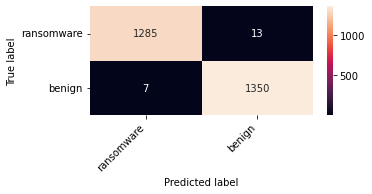

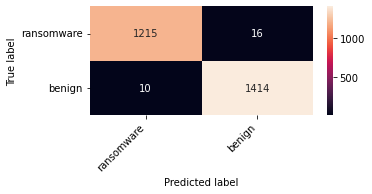

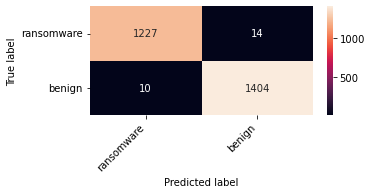

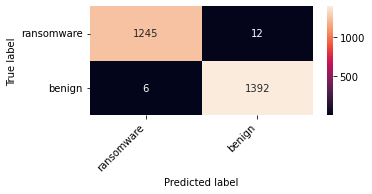

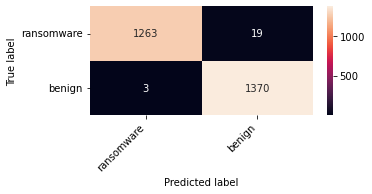

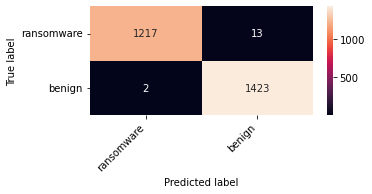

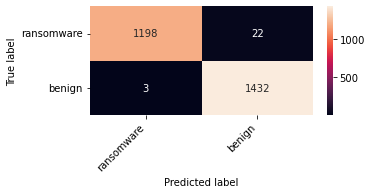

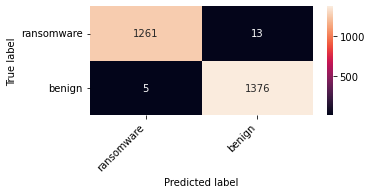

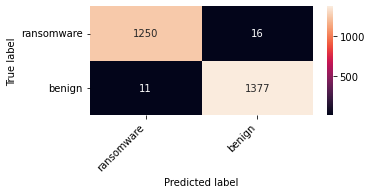

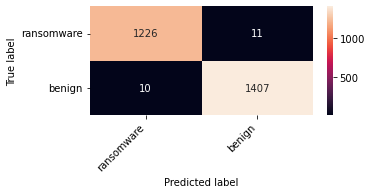

In [21]:
fold_no = 1

for train, test in kfold.split(imgs,labels):
    
    # Add generated images to training data   
    train_images = np.concatenate((imgs[train], imgs_gen), axis = 0)
    train_labels = to_categorical(np.concatenate((np.argmax(labels[train], axis = 1), np.argmax(labels_gen, axis = 1)), axis = 0))

    # DenseNet169
    base_model = tf.keras.applications.DenseNet169(weights = 'imagenet', include_top = False, input_shape = (64,64,3))
    
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(1000, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation = 'softmax')(x)
    
    # Compile the model
    head_model = Model(inputs = base_model.input, outputs = predictions)
    head_model.compile(optimizer='adam', loss=losses.categorical_crossentropy, metrics=['accuracy'])
    
    # Freeze all but last eight layers
    for layer in head_model.layers[:-8]:
        layer.trainable=False
    
    for layer in head_model.layers[-8:]:
        layer.trainable=True
    
    # Run the CNN
    history.append(
        head_model.fit(
        train_images, 
        train_labels, 
        validation_data=(imgs[test], labels[test]), 
        epochs=epoch_t,
        callbacks = [anne, checkpoint]) # The actual computation of the CNN
    )
    
    
    
    
    # Generate generalization metrics
    scores = head_model.evaluate(imgs[test], labels[test], verbose=0)
    print(f'Score for fold {fold_no}: {head_model.metrics_names[0]} of {scores[0]}; {head_model.metrics_names[1]} of {scores[1]*100}%')
    multi_acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
    # Create two 1D-arrays: one with the prediction per image of the model and one with the true labels
    y_pred = np.append(y_pred, np.argmax(head_model.predict(imgs[test]), axis=-1))
    y_true = np.append(y_true, np.argmax(labels[test], axis=1))
    
    y_pred2 = np.argmax(head_model.predict(imgs[test]), axis=-1)
    y_true2 = np.argmax(labels[test], axis=1)
    
    # Binary
    y_predbin = [] 
    y_truebin = []
    for count, value in enumerate(y_true2):
        if y_true2[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
            y_truebin.append(0)
        else: y_truebin.append(1) # if prediction is not one of the ransomware families, then it is benign

        if y_pred2[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
            y_predbin.append(0)
        else: y_predbin.append(1) # if prediction is not one of the ransomware families, then it is benign
        continue
        
    rw_count.append(len(y_truebin) - np.sum(y_truebin))
    bn_count.append(np.sum(y_truebin))
    
    # Binary confusion Matrix
    c_matrix_bin = metrics.confusion_matrix(y_truebin, y_predbin)
    
    # Plot the confusion matrix
    confusion_matrix(c_matrix_bin, class_names_bin, figsize = (5,2), fontsize=10)
    
    # Save the true/false positives/negatives    
    tp.append(c_matrix_bin[0,0])
    fp.append(c_matrix_bin[0,1])
    fn.append(c_matrix_bin[1,0])
    tn.append(c_matrix_bin[1,1])
    
    # Save the performance metrics used to compare the models
    multi_f1_per_fold.append(f1_score(y_true2, y_pred2, average='macro'))
    bin_tpr_per_fold.append(c_matrix_bin[0,0]/(c_matrix_bin[0,0] + c_matrix_bin[0,1])) #True Positive Rate
    bin_acc_per_fold.append(accuracy_score(y_truebin, y_predbin)) # Accuracy
    bin_f1_per_fold.append(f1_score(y_truebin, y_predbin, labels=0)) # F1 Score
    bin_mcc_per_fold.append(matthews_corrcoef(y_truebin, y_predbin))  # Matthews Correlation Coefficient
    
    # Save the multi-class data distribution
    train_distr.append((sum(train_labels)/train_labels.shape[0])*100)
    test_distr.append((sum(labels[test])/labels[test].shape[0])*100)    

Cross validation run overview

In [22]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(multi_acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {multi_acc_per_fold[i]*100}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(multi_acc_per_fold)*100}% (+- {np.std(multi_acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.2223854660987854 - Accuracy: 95.14124393463135%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.18263942003250122 - Accuracy: 96.4595079421997%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.19151145219802856 - Accuracy: 96.38417959213257%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.1619066298007965 - Accuracy: 96.9114899635315%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.15162399411201477 - Accuracy: 96.9114899635315%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.15147818624973297 - Accuracy: 97.0244824886322%
------------------------------------------------------------------------

# Evaluating performance

Create data distribution graph

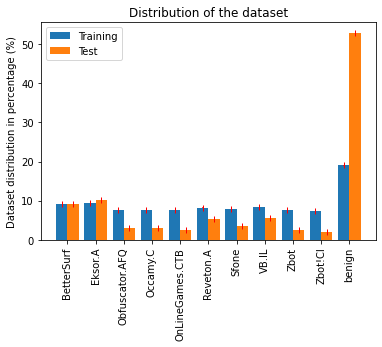

In [23]:
perc_train = np.mean(train_distr, axis = 0)
perc_test =  np.mean(test_distr, axis = 0)

plt.bar(x_axis - 0.2, perc_train, 0.4, label = 'Training')
plt.errorbar(x_axis - 0.2, perc_train, yerr = np.std(train_distr, axis = 0), 
             fmt='|', color='red', capsize = 0)

plt.bar(x_axis + 0.2, perc_test,0.4, label = 'Test')
plt.errorbar(x_axis + 0.2, perc_test, yerr = np.std(train_distr, axis = 0), 
             fmt='|', color='red', capsize=0.0)


plt.title('Distribution of the dataset')
plt.ylabel('Dataset distribution in percentage (%)')
plt.xticks(x_axis, list(classes), rotation='vertical')
plt.legend()

if cenv == 0:
    plt.savefig("multi_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/multi_data_dist.png", bbox_inches = 'tight', dpi = 150)

In [24]:
t = PrettyTable(['Metric', 'Performance', 'St.Deviation'])
t.add_row(['M-Class', "", ""])
t.add_row(['Acc    ', round(np.mean(multi_acc_per_fold),4), round(np.std(multi_acc_per_fold),4)])
t.add_row(['Loss   ', round(np.mean(loss_per_fold),4), round(np.std(loss_per_fold),4)])
t.add_row(['Macro F1', round(np.mean(multi_f1_per_fold), 4), round(np.std(multi_f1_per_fold),4)])
t.border = True
t.add_row(['', '', ''])
t.add_row(['B-Class', "", ""])
t.add_row(['TPR    ', round(np.mean(bin_tpr_per_fold),4), round(np.std(bin_tpr_per_fold),4)])
t.add_row(['Acc    ', round(np.mean(bin_acc_per_fold),4), round(np.std(bin_acc_per_fold),4)])
t.add_row(['F1     ', round(np.mean(bin_f1_per_fold),4), round(np.std(bin_f1_per_fold),4)])
t.add_row(['MCC    ', round(np.mean(bin_mcc_per_fold),4), round(np.std(bin_mcc_per_fold),4)])
t.header = True
t.set_style(MSWORD_FRIENDLY)
t.align = "l"
t.title = "Performance of CGAN-DenseNet"
print(t)

+---------------------------------------+
|      Performance of CGAN-DenseNet     |
| Metric   | Performance | St.Deviation |
| M-Class  |             |              |
| Acc      | 0.9649      | 0.0054       |
| Loss     | 0.1856      | 0.0349       |
| Macro F1 | 0.9067      | 0.0101       |
|          |             |              |
| B-Class  |             |              |
| TPR      | 0.9881      | 0.0027       |
| Acc      | 0.9919      | 0.0014       |
| F1       | 0.9923      | 0.0013       |
| MCC      | 0.9837      | 0.0028       |


In [25]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('multi_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/multi_performance_table.txt', 'w') as f:
        f.write(table)

Evaluate the model based on the test set

Save a table with the performance on the test set

**Evaluating overfitting and other model performance measures**

In [26]:
linecolours = ['gray', 'orange', 'blue', 'green','silver', 'cyan', 'red', 'purple', 'lightgreen', 'black', 'brown']

In [27]:
def eval_metric(model, history, metric_name, ymin, ymax):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    for i in range(n_folds-1):  
        metric = history[i].history[metric_name]
        val_metric = history[i].history['val_' + metric_name]
        e = range(1, epoch_t + 1)
        plt.plot(e, metric, marker = 'o', linestyle = 'none', color = linecolours[i])
        plt.plot(e, val_metric, color = linecolours[i])
        
    metric = history[n_folds-1].history[metric_name]
    val_metric = history[n_folds-1].history['val_' + metric_name]
    e = range(1, epoch_t + 1)
    plt.plot(e, metric, marker = 'o', linestyle = 'none', label = 'Training', color = linecolours[n_folds-1])
    plt.plot(e, val_metric, label = 'Validation', color = linecolours[n_folds-1])
    
    plt.ylim(ymin, ymax)
    
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for CGAN-DenseNet across folds')
    plt.legend()
    if cenv == 0:
        plt.savefig(f"cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)

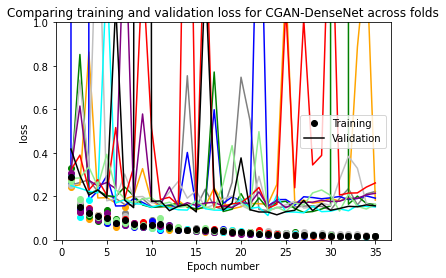

In [28]:
eval_metric(head_model, history, 'loss', 0,1)

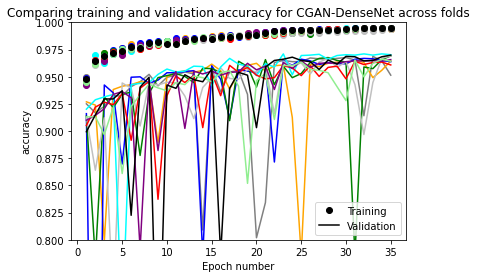

In [29]:
eval_metric(head_model, history, 'accuracy', 0.8,1)

# Confusion Matrix
Analysing the results

# Binary classification
y_predbin and y_testbin are the binary classification arrays. 0 = ransomware and 1 = benign

Plot the distribution of dataset as ransomware - benign

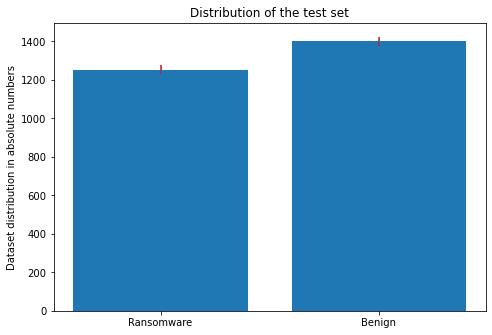

In [30]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_lab = ['Ransomware', 'Benign']
y_lab = [np.mean(rw_count), np.mean(bn_count)]
plt.title('Distribution of the test set')
plt.ylabel('Dataset distribution in absolute numbers')
ax.bar(x_lab, y_lab)
ax.errorbar(x_lab, y_lab, yerr = [np.std(rw_count), np.std(bn_count)], fmt = '|', ecolor='red')
if cenv == 0:
    plt.savefig("bin_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/bin_data_dist.png", bbox_inches = 'tight', dpi = 150)

Plot binary confusion matrix

In [31]:
all_y_predbin = [] 
all_y_truebin = []
for count, value in enumerate(y_true):
    if y_true[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
        all_y_truebin.append(0)
    else: all_y_truebin.append(1) # if prediction is not one of the ransomware families, then it is benign

    if y_pred[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
        all_y_predbin.append(0)
    else: all_y_predbin.append(1) # if prediction is not one of the ransomware families, then it is benign
    continue

In [32]:
def confusion_matrix_bin(confusion_matrix, class_names_bin, name, figsize = (5,2), fontsize=7):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names_bin, columns=class_names_bin, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f"{(name.capitalize())} Confusion Matrix - CGAN-DenseNet")
    if cenv == 0:
        plt.savefig(f"{name}_cmatrix.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/{name}_cmatrix.png", bbox_inches = 'tight', dpi = 150)

In [33]:
c_matrix_bin = metrics.confusion_matrix(all_y_truebin, all_y_predbin)

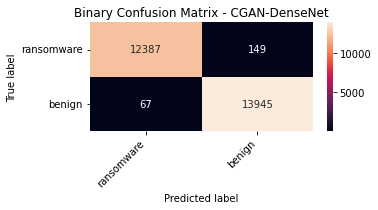

In [34]:
class_names_bin= ("ransomware", "benign")
confusion_matrix_bin(c_matrix_bin, class_names_bin, 'binary', figsize = (5,2), fontsize=10)

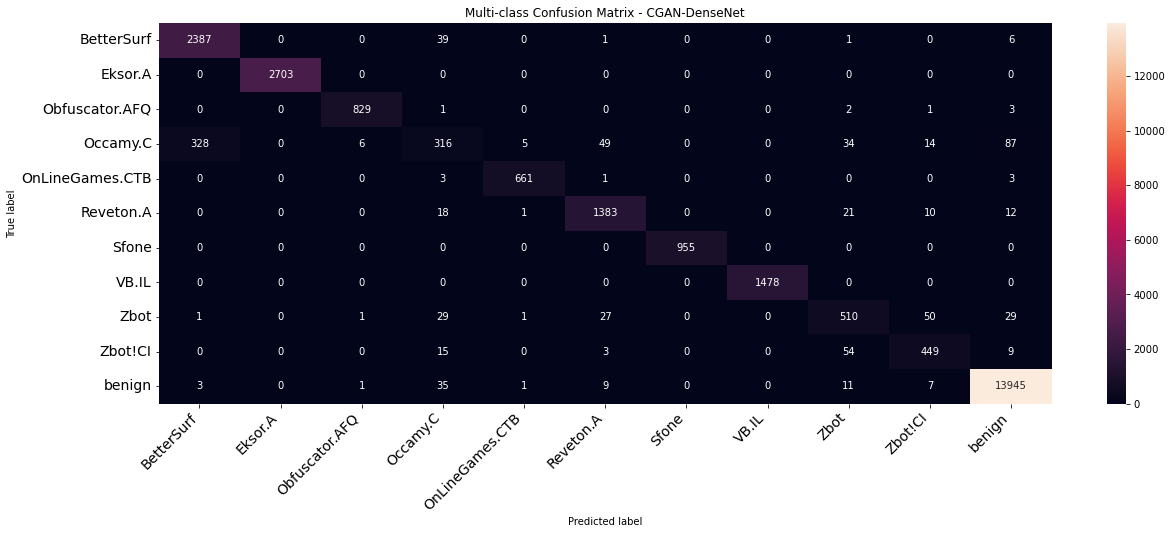

In [35]:
c_matrix = metrics.confusion_matrix(y_true, y_pred)
class_names= batches.class_indices.keys()
confusion_matrix_bin(c_matrix, class_names, 'multi-class', figsize = (20,7), fontsize=14)